# Objective

Introduce TensorFlow Serving as an integrated service for model deployment

In [1]:
!pip install tensorflow==2.12.1

In [2]:
import tensorflow as tf

In [3]:
import os
import json
import requests
import tempfile

import numpy as np
import tensorflow as tf

from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile

In [4]:
tf.__version__

'2.12.1'

# Introduction

There are two key infrastructure components that form the vast majority of ML deployments - web (API) deployment and edge deployment. Deploying ML models on the web is helpful to balance the costs incurred in serving complex models and the resources available to serve these models. Since the serving infrastructure can be controlled, API-driven deployment is often scalable in terms of performance. Given a model, we typically start with a specification of the serving infrastructure, and keep the specification constant until the cap on predictive performance is maintained (monitoring is crucial).

If performance (i.e., latency, througput and cost) degrades, we revisit the serving infrastructure and change if necessary.

A common way to deploy a model on the web is to wrap the saved model as a API service and allow users (clients) to send requests. The requests are parsed into the appropriate input format and presented to the model for inference. This inference is returned to the user as a response.

Common web frameworks used in production are [Flask](https://flask.palletsprojects.com/en/2.1.x/) and [FastAPI](https://fastapi.tiangolo.com/).

A recent addition to web-based serving is [TensorFlow Serving](https://www.tensorflow.org/tfx/tutorials/serving/rest_simple) - a crucial cog in the broader [TensorFlow Extended](https://www.tensorflow.org/tfx) ecosystem. In this exercise, you will perform a deep into TensorFlow Serving.

The first task is designed to take you through the steps involved in deploying a pre-trained model using TensorFlow Serving. For the second task, you will have to deploy any pretrained model as a separate end point.

# Task 1: Deploying a Pre-trained Model

Execute the following steps.

## Step 1: Upload and inspect a pre-trained model

A pretrained bean leaf disease predictor is attached as a supporting file (`bean-leaf-predictor-efficientnet.zip`) with this exercise. Upload this file to the Colab instance and load this `SavedModel` and inspect its contents.

In [5]:
! unzip bean-leaf-predictor-efficientnet.zip

Archive:  bean-leaf-predictor-efficientnet.zip
   creating: bean-leaf-predictor-efficientnet/
  inflating: __MACOSX/._bean-leaf-predictor-efficientnet  
  inflating: bean-leaf-predictor-efficientnet/keras_metadata.pb  
  inflating: __MACOSX/bean-leaf-predictor-efficientnet/._keras_metadata.pb  
   creating: bean-leaf-predictor-efficientnet/variables/
  inflating: __MACOSX/bean-leaf-predictor-efficientnet/._variables  
  inflating: bean-leaf-predictor-efficientnet/saved_model.pb  
  inflating: __MACOSX/bean-leaf-predictor-efficientnet/._saved_model.pb  
   creating: bean-leaf-predictor-efficientnet/assets/
  inflating: __MACOSX/bean-leaf-predictor-efficientnet/._assets  
  inflating: bean-leaf-predictor-efficientnet/variables/variables.data-00000-of-00001  
  inflating: __MACOSX/bean-leaf-predictor-efficientnet/variables/._variables.data-00000-of-00001  
  inflating: bean-leaf-predictor-efficientnet/variables/variables.index  
  inflating: __MACOSX/bean-leaf-predictor-efficientnet/varia

In [6]:
saved_model_path = 'bean-leaf-predictor-efficientnet'
print(f'\nFiles of model saved in {saved_model_path }:\n')
!ls -lh {saved_model_path}


Files of model saved in bean-leaf-predictor-efficientnet:

total 6.6M
drwxr-xr-x 2 root root 4.0K Jan 27  2023 assets
-rw-r--r-- 1 root root 745K Jan 27  2023 keras_metadata.pb
-rw-r--r-- 1 root root 5.9M Jan 27  2023 saved_model.pb
drwxr-xr-x 2 root root 4.0K Jan 27  2023 variables


As the output above indicates, a `SavedModel` comprises the following four components:
- `assets`:  a collection of files used by TensorFlow to build the computation graph
- `variables`: Information of checkpoints used during training
- `saved_model.pb`: A protobuf file that represents the model
- `keras_metadata.pb`: A protobuf file that represents the metadata that is added by Keras (e.g., base model metadata)  

Note that so far we have not yet loaded our model. We can directly interact with the protobuf files to extract information of the model. For example, we can query the saved model to understand the inputs and outputs from the model (`saved_model_cli` is pre-installed with TensorFlow in Google Colab).

In [7]:
!saved_model_cli show --dir {saved_model_path}

2025-02-15 06:36:16.455371: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
The given SavedModel contains the following tag-sets:
'serve'


Notice that the `SavedModel` is tagged with the label 'serve'. Since we are concerned with the input and output components of the saved model, we can inspect these components of the model like so:

In [8]:
!saved_model_cli show --dir {saved_model_path} \
                      --tag_set serve \
                      --signature_def serving_default

2025-02-15 06:36:20.832194: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
The given SavedModel SignatureDef contains the following input(s):
  inputs['input_2'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 224, 224, 3)
      name: serving_default_input_2:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['dense'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 3)
      name: StatefulPartitionedCall:0
Method name is: tensorflow/serving/predict


As we can see from the output above, the model expects an image of size (224, 224) and outputs a floating point array of with three numbers. Each of these corresponds to the output from the 3 `Dense` units in the final layer of the pre-trained model (more on the architecture of the model shortly).

We could also inspect the full computational graph stored by the model like so:

In [9]:
!saved_model_cli show --dir {saved_model_path} --all

2025-02-15 06:36:29.430485: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['input_2'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 224, 224, 3)
        name: serving_default_input_2:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['dense'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 3)
        name: StatefulPartitionedCall:0
  Method name is: tensorflow/serving/predict
The Meta

Of course, loading the model using TensorFlow gives us access to the architecture + weights of the pretrained model.

In [10]:
model_final = tf.keras.models.load_model(saved_model_path)

In [11]:
model_final.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 3)                 3843      
                                                                 
Total params: 4,053,414
Trainable params: 4,011,391
Non-trainable params: 42,023
_________________________________________________________________


## Step 2: Prepare the saved model for serving

Let us save this model into a temporary folder on the machine. This is a requirement for TensorFlow Serving (and in general a good practise).

Note how the model to be served is saved in the corresponding version folder. This allows Tensorflow Serving to automatically pick up the version information while exposing the API. Also, we could serve multiple versions of our model through different endpoints (very helpful in A/B testing).

We begin by creating a temporary folder and a subdirectory with the version. Think of this as a *staging* area before hosting the model to a permanent endpoint.

In [12]:
MODEL_DIR = tempfile.gettempdir()

In [13]:
version = 1
export_path = os.path.join(MODEL_DIR, str(version))
print(f'export_path = {export_path}\n')

export_path = /tmp/1



Let us now save the pre-trained model to this temporary directory.

In [14]:
# Save the model
tf.keras.models.save_model(model_final,
                           export_path,
                           overwrite=True,
                           include_optimizer=True,
                           save_format=None,
                           signatures=None,
                           options=None)

## Step 3: Install TensorFlow Serving

Let us now install [TensorFlow Serving](https://www.tensorflow.org/tfx/tutorials/serving/rest_simple). Note that we are installing a Colab compatible version here.

In [15]:
url = "https://storage.googleapis.com/tensorflow-serving-apt"
src = "stable tensorflow-model-server tensorflow-model-server-universal"

!echo 'deb {url} {src}' > /etc/apt/sources.list.d/tensorflow-serving.list
!curl '{url}/tensorflow-serving.release.pub.gpg' | apt-key add -
!apt update -q && apt-get install -y tensorflow-model-server

%pip install -q -U tensorflow-serving-api

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0Warning: apt-key is deprecated. Manage keyring files in trusted.gpg.d instead (see apt-key(8)).
100  2943  100  2943    0     0   6055      0 --:--:-- --:--:-- --:--:--  6068
OK
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,315 kB]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:7 https://storage.googleapis.com/tensorflow-serving-apt stable InRelease [3,026 B]
Get:8 http:/

## Step 4: Start a TensorFlow server

We begin by creating a global variable `MODEL_DIR` pointing to the temporary folder we just created.

In [16]:
os.environ["MODEL_DIR"] = MODEL_DIR

Time now to spin up the server.

In [17]:
%%bash --bg
nohup tensorflow_model_server \
  --rest_api_port=8501 \
  --model_name=bean_leaf_classifier \
  --model_base_path="${MODEL_DIR}" >server.log 2>&1

Note how we are asking TensorFlow Serving to open up a REST API on port 8501. We also specify a model name `bean_leaf_classifier` that will again be used when we send requests to the server.

In [18]:
!tail server.log

I0000 00:00:1739601633.654100    3848 loader_harness.cc:71] Approving load for servable version {name: bean_leaf_classifier version: 1}
I0000 00:00:1739601633.654300    3848 loader_harness.cc:79] Loading servable version {name: bean_leaf_classifier version: 1}
I0000 00:00:1739601634.598570    3848 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled


The log indicates that the server is ready for predictions. Let us prepare some images from the validation data to be sent to the server for predictions.

## Step 5: Prepare test data

In [19]:
TEST_DIR = '/tmp/bean/test'

BATCH_SIZE = 16

IMAGE_SIZE = (224, 224)

In [20]:
test_data_url = 'https://storage.googleapis.com/ibeans/test.zip'

In [21]:
with urlopen(test_data_url) as zipped_file:
    with ZipFile(BytesIO(zipped_file.read())) as zfile:
        zfile.extractall('/tmp/bean')

Let us now create a data generator that points to the test images folder.

In [22]:
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

# Point to the directory with the test images
test_gen = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

# Print the label that is assigned to each class
print(f"labels for each class in the test generator are encoded as: {test_gen.class_indices}")

Found 128 images belonging to 3 classes.
labels for each class in the test generator are encoded as: {'angular_leaf_spot': 0, 'bean_rust': 1, 'healthy': 2}


In [23]:
# Get a batch of 16 images along with their true label
data_imgs, labels = next(test_gen)

# Check shapes
print(f"data_imgs has shape: {data_imgs.shape}")
print(f"labels has shape: {labels.shape}")

data_imgs has shape: (16, 224, 224, 3)
labels has shape: (16, 3)


Convert the numpy array to a list.

In [24]:
data_imgs_list = data_imgs.tolist()

Dump this list into a `json` object. This object will form the payload for the request.

In [25]:
data = json.dumps({"instances": data_imgs_list})

## Step 6: Send requests to the server

The model endpoint is located at: `http://localhost:8501/v1/models/bean_leaf_classifier:predict`. This endpoint is automatically generated by TensorFlow serving.

We post our payload to this endpoint for a response.

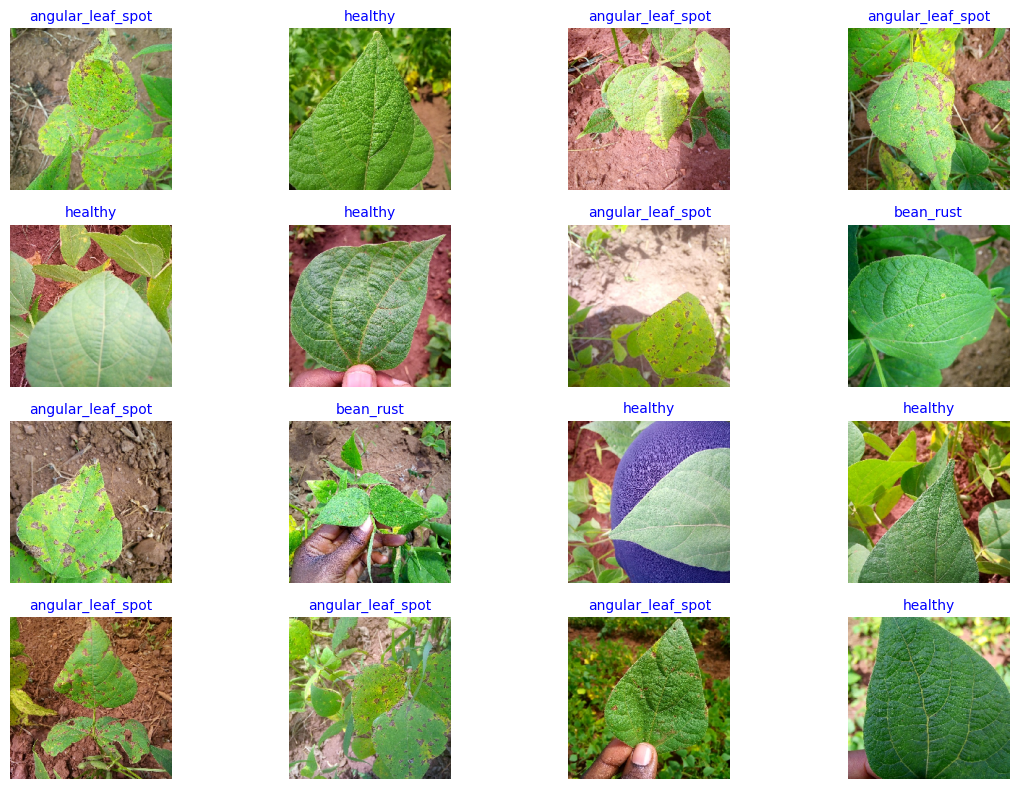

In [26]:
import matplotlib.pyplot as plt

# Define headers for request
headers = {"content-type": "application/json"}

# Send request to TensorFlow Model Server
json_response = requests.post(
    'http://localhost:8501/v1/models/bean_leaf_classifier:predict',
    data=data,
    headers=headers
)

# Parse predictions
predictions = json.loads(json_response.text)['predictions']
predicted_class_indices = np.argmax(predictions, axis=1)  # Get predicted class indices

# Get class labels mapping
class_indices = test_gen.class_indices  # {'healthy': 0, 'diseased': 1, 'infected': 2}
index_to_class = {v: k for k, v in class_indices.items()}  # Reverse mapping

# Convert indices to class labels
predicted_labels = [index_to_class[idx] for idx in predicted_class_indices]

# Plot images with their predicted class labels
plt.figure(figsize=(12, 8))

for i in range(len(data_imgs)):  # Loop through all images in batch
    plt.subplot(4, 4, i + 1)  # Create a 4x4 grid
    plt.imshow(data_imgs[i].astype("uint8"))  # Convert to proper format
    plt.axis('off')  # Hide axes
    plt.title(predicted_labels[i], fontsize=10, color='blue')  # Show predicted class

plt.tight_layout()
plt.show()

## Step 7: Compare predictions with ground truth

Let us first collect the predictions from the server to a label.

In [27]:
preds = np.argmax(predictions, axis=1)

In [28]:
preds

array([0, 2, 0, 0, 2, 2, 0, 1, 0, 1, 2, 2, 0, 0, 0, 2])

Let us now look at the ground truth.

In [32]:
label=np.argmax(labels, axis=1)

In [33]:
accuracy = np.mean(preds == label)
accuracy*100

100.0